In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# tbh personally would be more interested in ranking, d_ranking, etc

In [3]:
S_ROOT = r'data/'

In [4]:
df_createrole_login = pd.read_csv(S_ROOT + 'createrole_login_record.csv')
df_session = pd.read_csv(S_ROOT + 'user_daily_session_length_record.csv')
df_p = pd.read_csv(S_ROOT + 'user_payment_record.csv').rename({'date':'dt'}, axis=1)

In [5]:
df_createrole_login

,appid,dt,ctwid,server_id,type,time
0,test,2024-11-17,84a787b8d4,44,g_login,1731843941000
1,test,2024-11-17,42fa4799c1,34,g_login,1731843977000
2,test,2024-11-17,96c22d3440,60,g_login,1731843979000
3,test,2024-11-17,def76d1d2b,9,g_login,1731843937000
4,test,2024-11-17,5ece9bf10e,18,g_login,1731843984000
...,...,...,...,...,...,...
3832730,test,2024-10-18,f42abc1ce5,1,g_login,1729263590000
3832731,test,2024-10-18,be64dcba91,1,g_login,1729263529000
3832732,test,2024-10-18,e7b71af6bf,1,g_login,1729263598000
3832733,test,2024-11-03,745a5a9d69,3,g_login,1730645998000


In [6]:
df_session

,appid,dt,ctwid,session_length
0,test,2024-11-17,a512b8cf9b,17
1,test,2024-11-17,5601d6307c,1898
2,test,2024-11-17,a0e52a52cc,1894
3,test,2024-11-17,88321a495c,1
4,test,2024-11-17,0d649666d6,6185
...,...,...,...,...
2755439,test,2024-10-29,8f3fd1c742,12947
2755440,test,2024-10-29,3a6d1ab888,316
2755441,test,2024-10-29,a7659fd0d9,5295
2755442,test,2024-10-29,538844702d,601


In [7]:
df_p

,appid,dt,ctwid,server_id,time,pay_amt
0,test,2024-11-13,23dccf736f,2,1731509951124,100
1,test,2024-11-13,2cac52ff60,3,1731509996850,100
2,test,2024-11-13,af687842ae,43,1731509995400,100
3,test,2024-11-14,44f3cee987,43,1731510028964,1
4,test,2024-11-14,01c6034980,9,1731510053112,79
...,...,...,...,...,...,...
106505,test,2024-11-06,67e0a2383a,4,1730904349467,100
106506,test,2024-11-06,2d019a85af,4,1730904653874,100
106507,test,2024-11-06,a9fff2307d,8,1730904862305,100
106508,test,2024-11-06,e64eb351e8,14,1730905048959,1


In [8]:
for df in (df_createrole_login, df_session, df_p):
    df['dt'] = pd.to_datetime(df['dt'])

In [9]:
# Data check

df_createrole_login_unique = df_createrole_login.groupby(['ctwid', 'dt'])['type'].count()\
    .reset_index().rename({'type': 'createrole_login_records'}, axis=1)
df_createrole_login_unique['createrole_login_records'] = 1

df_session_unique = df_session.groupby(['ctwid', 'dt'])['session_length'].count()\
    .reset_index().rename({'session_length': 'session_records'}, axis=1)
df_session_unique['session_records'] = 1
    
df_payment_unique = df_p.groupby(['ctwid', 'dt'])['pay_amt'].count()\
    .reset_index().rename({'pay_amt': 'payment_records'}, axis=1)
df_payment_unique['payment_records'] = 1

tup_names = ('createrole_login', 'session', 'payment')
for s1 in tup_names:
    for s2 in tup_names:
        if s1 != s2:
            df = locals()['df_'+s1+'_unique'].merge(locals()['df_'+s2+'_unique'], how='left', on=['ctwid', 'dt']).fillna(0)\
                .groupby(s2+'_records').count()
            print(s1 + ' records in ' + s2)
            print(df)
            print()

# Conclusion: will use createrole_login as the main user source.

createrole_login records in session
                  ctwid      dt  createrole_login_records
session_records                                          
1                846017  846017                    846017

createrole_login records in payment
                  ctwid      dt  createrole_login_records
payment_records                                          
0.0              810899  810899                    810899
1.0               35118   35118                     35118

session records in createrole_login
                            ctwid       dt  session_records
createrole_login_records                                   
0.0                       1909427  1909427          1909427
1.0                        846017   846017           846017

session records in payment
                   ctwid       dt  session_records
payment_records                                   
0.0              2720261  2720261          2720261
1.0                35183    35183            35183

payment rec

In [32]:
# Player status
df_player_payment = df_p.groupby(['ctwid', 'server_id', 'dt'])['pay_amt'].sum().reset_index()
df_player_payment['pay_count'] = df_p.groupby(['ctwid', 'server_id', 'dt'])['pay_amt'].count().values

df_player_status = df_session[['dt', 'ctwid', 'session_length']].merge(df_player_payment, how='left', on=['ctwid', 'dt'])
df_player_status = df_player_status.drop(columns=['server_id'])

df_player_login = df_createrole_login.groupby(['ctwid', 'server_id', 'dt'])['type'].count().reset_index()\
    .rename({'type': 'session_count'}, axis=1)
df_player_status = df_player_status.merge(df_player_login, how='inner', on=['ctwid', 'dt']).fillna(0.0)

df_player_status['acc_pay_amt'] = df_player_status.groupby(['ctwid', 'server_id'])['pay_amt'].rolling(999, min_periods=1).sum().values
df_player_status['acc_pay_count'] = df_player_status.groupby(['ctwid', 'server_id'])['pay_count'].rolling(999, min_periods=1).sum().values

df_player_status = df_player_status[df_player_status['server_id'] > 0]

df_player_status['retention_day'] = [x.days for x in df_player_status['dt'] - df_player_status.groupby('ctwid')['dt'].transform('min')]

df_player_status

,dt,ctwid,session_length,pay_amt,pay_count,server_id,session_count,acc_pay_amt,acc_pay_count,retention_day
0,2024-11-17,5601d6307c,1898,0.0,0.0,3,2,0.0,0.0,25
1,2024-11-17,a0e52a52cc,1894,0.0,0.0,64,2,0.0,0.0,0
2,2024-11-17,0d649666d6,6185,0.0,0.0,33,7,0.0,0.0,5
3,2024-11-17,bd6edaf313,11660,0.0,0.0,20,3,0.0,0.0,8
4,2024-11-17,7062c3074b,26,0.0,0.0,62,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
853568,2024-10-29,ca2390dd3c,528,0.0,0.0,9,2,0.0,0.0,0
853569,2024-10-29,8f3fd1c742,12947,0.0,0.0,1,5,0.0,0.0,10
853570,2024-10-29,3a6d1ab888,316,0.0,0.0,3,2,0.0,0.0,6
853571,2024-10-29,a7659fd0d9,5295,0.0,0.0,5,6,0.0,0.0,5


In [40]:
# Server status
df_createrole = df_player_status.groupby(['ctwid', 'server_id'])['dt'].min().reset_index()
df_server_creation = df_createrole.groupby('server_id')['dt'].min().reset_index().rename({'dt':'server_creation_dt'}, axis=1)

df_server_status = df_createrole.groupby(['server_id', 'dt'])['ctwid']\
    .count().reset_index().rename({'ctwid':'server_new_account'}, axis=1)
df_server_status['server_total_account'] = df_server_status.groupby('server_id')['server_new_account']\
    .rolling(999, min_periods=1).sum().values
df_server_status = df_server_status.merge(df_server_creation, on='server_id')
df_server_status['server_day'] = [x.days for x in df_server_status['dt'] - df_server_status['server_creation_dt']]

df_server_login = df_player_status.groupby(['server_id', 'dt'])['session_count'].count()\
    .reset_index().rename({'session_count':'daily_active_account'}, axis=1)
df_server_status = df_server_status.merge(df_server_login, on=['server_id', 'dt'])

df_server_status = df_server_status.merge(df_player_status[df_player_status['pay_amt'] > 0].groupby(['server_id', 'dt'])\
                                          [['pay_amt', 'pay_count']].sum()\
                                          .rename({'pay_amt': 'sum_pay_amt', 'pay_count':'sum_pay_count'}, axis=1), 
                                          how='left', on=['server_id', 'dt'])

df_server_spenders = df_player_status[df_player_status['pay_amt'] > 0].groupby(['server_id', 'dt'])['ctwid'].count()\
    .reset_index().rename({'ctwid': 'spenders'}, axis=1)
df_server_status = df_server_status.merge(df_server_spenders, how='left', on=['server_id', 'dt'])

df_server_whales_1000 = df_player_status[df_player_status['acc_pay_amt'] > 1000].groupby(['server_id', 'dt'])['ctwid'].count()\
    .reset_index().rename({'ctwid': 'whales_1000'}, axis=1)  # this is a trivial number
df_server_status = df_server_status.merge(df_server_whales_1000, how='left', on=['server_id', 'dt'])

df_server_whales_10000 = df_player_status[df_player_status['acc_pay_amt'] > 10000].groupby(['server_id', 'dt'])['ctwid'].count()\
    .reset_index().rename({'ctwid': 'whales_10000'}, axis=1)  # this is a trivial number
df_server_status = df_server_status.merge(df_server_whales_10000, how='left', on=['server_id', 'dt'])

df_server_session = df_player_status.groupby(['server_id', 'dt'])[['session_length', 'session_count']].mean().reset_index()\
    .rename({'session_length': 'avg_session_length', 'session_count': 'avg_session_count'}, axis=1)
df_server_status = df_server_status.merge(df_server_session, how='left', on=['server_id', 'dt'])

df_server_status['arpdau'] = df_server_status['sum_pay_amt'] / df_server_status['daily_active_account']
df_server_status['daily_conversion'] = df_server_status['spenders'] / df_server_status['daily_active_account']
df_server_status['arppu'] = df_server_status['sum_pay_amt'] / df_server_status['spenders']

df_server_status

,server_id,dt,server_new_account,server_total_account,server_creation_dt,server_day,daily_active_account,sum_pay_amt,sum_pay_count,spenders,whales_1000,whales_10000,avg_session_length,avg_session_count,arpdau,daily_conversion,arppu
0,1,2024-10-18,2199,2199.0,2024-10-18,0,2199,486739.0,1093.0,377,122,32.0,4951.478399,5.554798,221.345612,0.171442,1291.084881
1,1,2024-10-19,1076,3275.0,2024-10-18,1,2054,579114.0,995.0,263,136,77.0,7874.709834,8.496105,281.944499,0.128043,2201.954373
2,1,2024-10-20,1462,4737.0,2024-10-18,2,2548,587047.0,835.0,262,136,36.0,7050.104788,8.671507,230.395212,0.102826,2240.637405
3,1,2024-10-21,1041,5778.0,2024-10-18,3,2353,494088.0,582.0,224,97,45.0,7544.686358,10.022099,209.982150,0.095198,2205.750000
4,1,2024-10-22,628,6406.0,2024-10-18,4,1967,478792.0,400.0,172,103,26.0,7686.944077,10.146924,243.412303,0.087443,2783.674419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,74,2024-11-18,5762,5762.0,2024-11-18,0,5764,118553.0,389.0,139,240,60.0,1367.038862,2.207148,20.567835,0.024115,852.899281
669,75,2024-11-18,5753,5753.0,2024-11-18,0,5754,132134.0,332.0,109,218,59.0,1226.737921,1.920056,22.963851,0.018943,1212.238532
670,76,2024-11-18,5726,5726.0,2024-11-18,0,5728,96780.0,293.0,104,240,60.0,1035.149092,1.764839,16.895950,0.018156,930.576923
671,77,2024-11-18,5822,5822.0,2024-11-18,0,5822,49774.0,184.0,90,253,69.0,888.711955,1.563896,8.549296,0.015459,553.044444


In [25]:
df_server_status.to_csv(S_ROOT + 'data_check.csv', index=False)

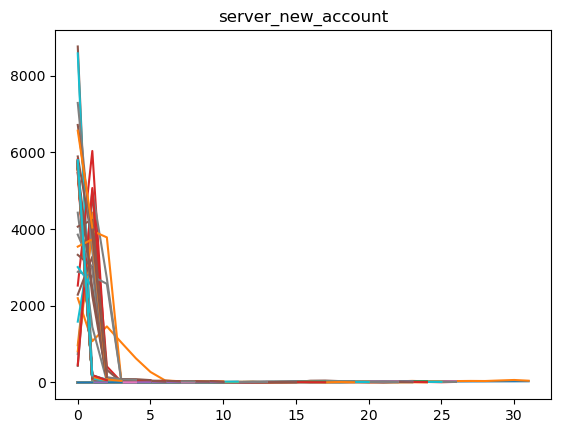

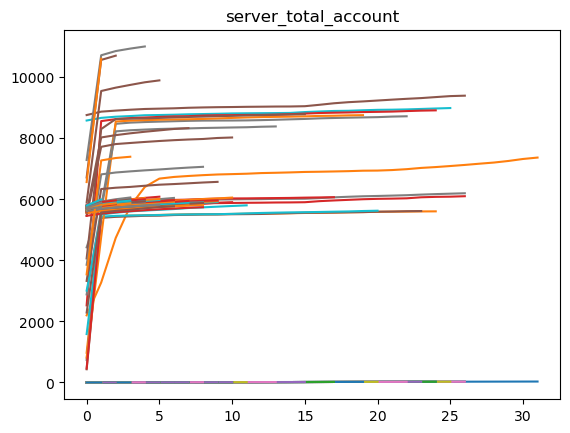

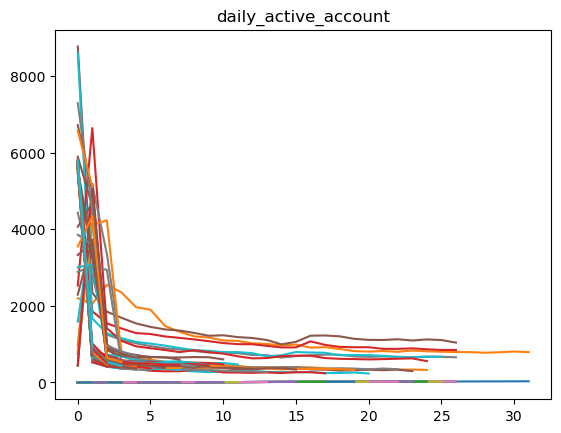

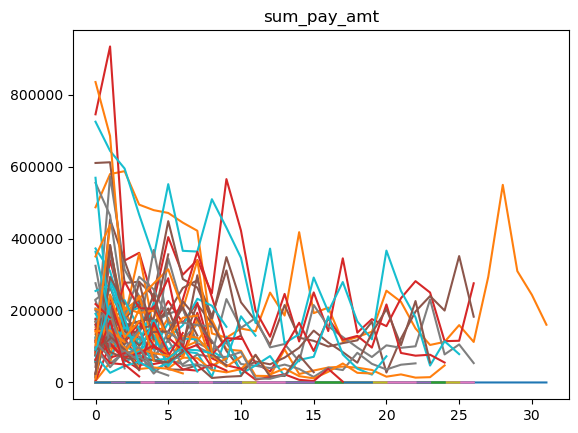

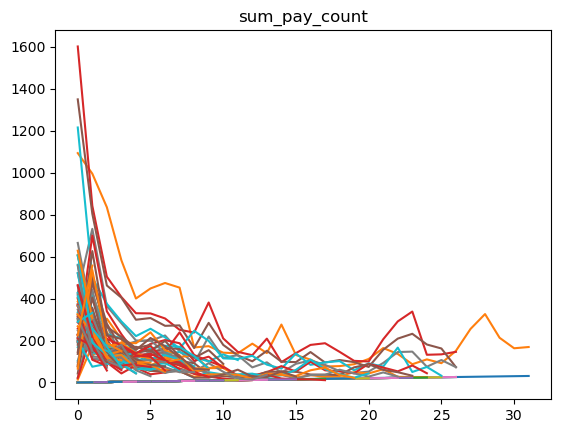

KeyError: "['whales'] not in index"

<Figure size 640x480 with 0 Axes>

In [41]:
for c in ('server_new_account', 'server_total_account', 'daily_active_account', 'sum_pay_amt', 'sum_pay_count', 'whales', 
          'arpdau', 'daily_conversion', 'arppu', 'avg_session_length', 'avg_session_count'):
    plt.figure()
    for server_id in range(1, 79):
        plt.plot(df_server_status.loc[df_server_status['server_id']==server_id, ['server_day', c]].values)
    plt.title(c)
    plt.show()

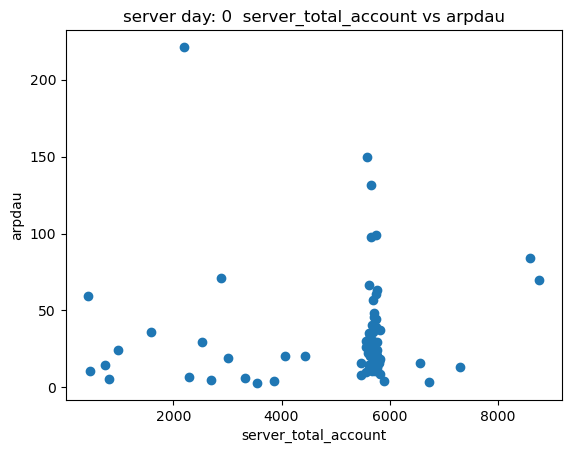

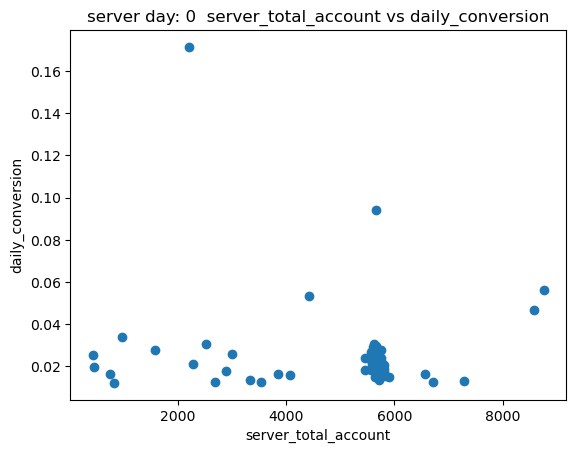

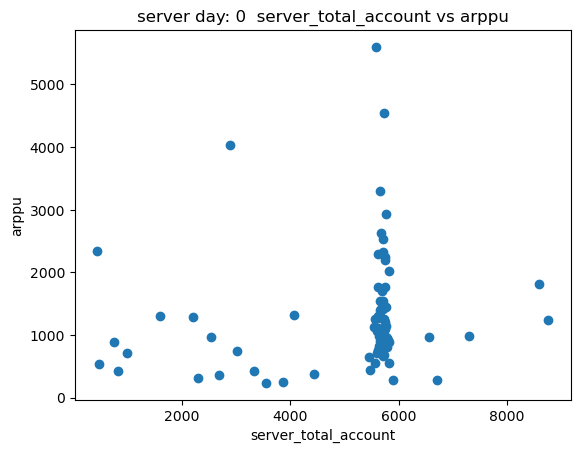

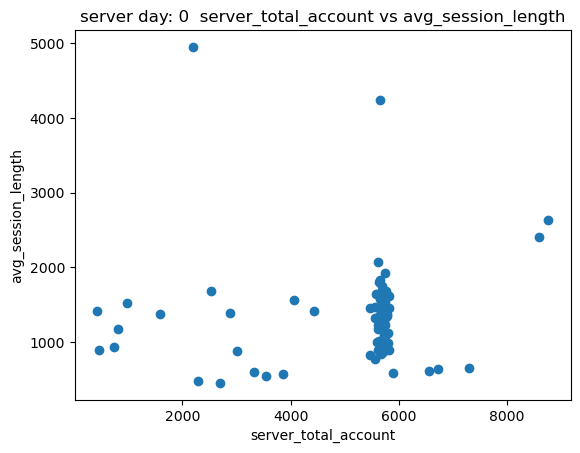

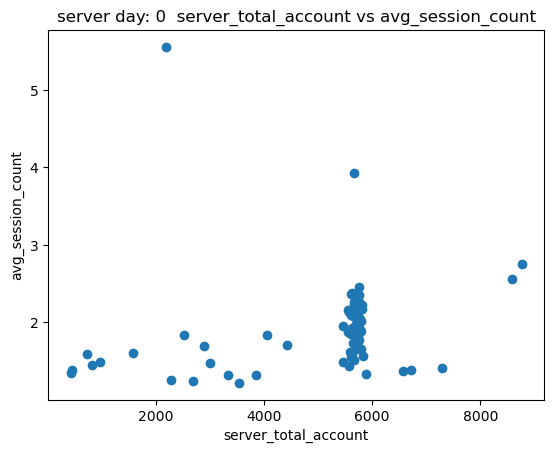

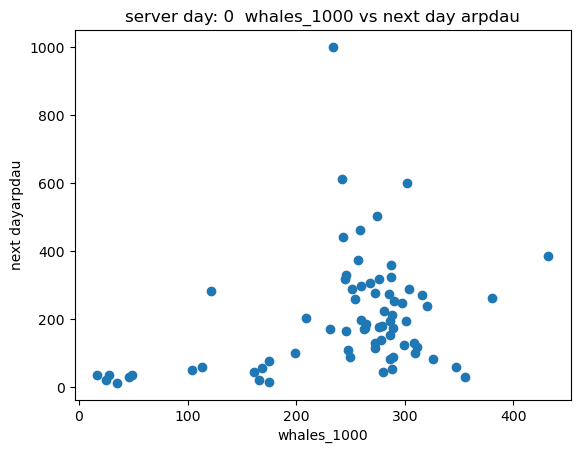

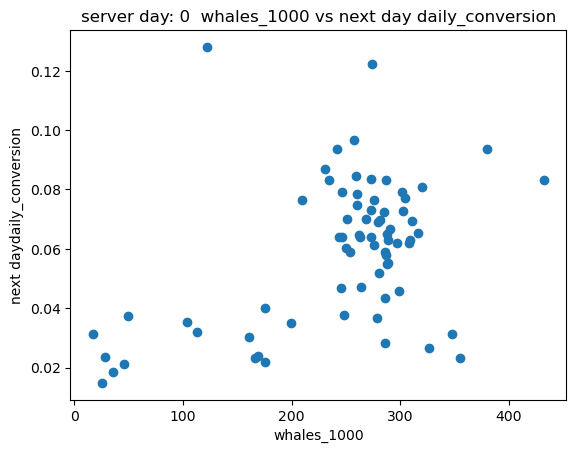

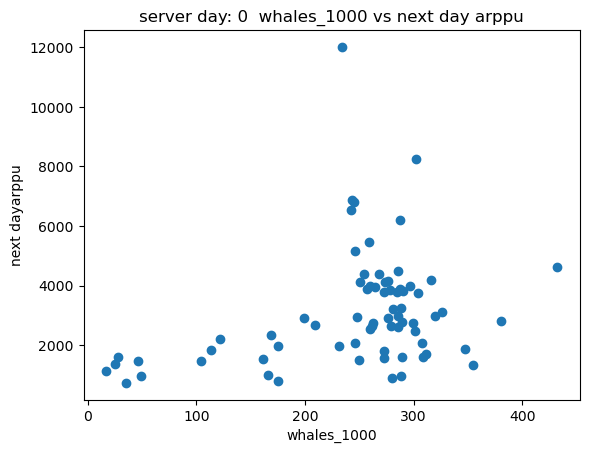

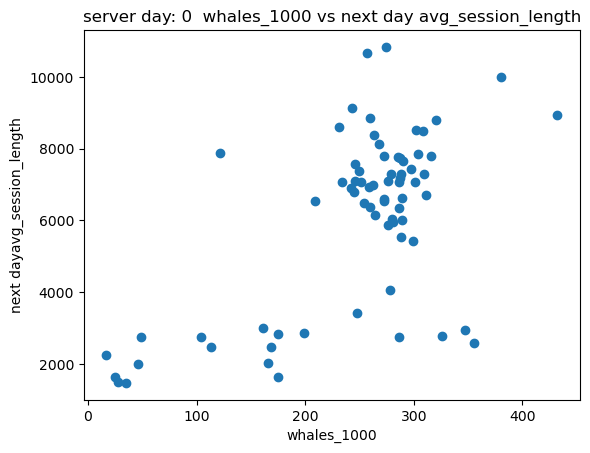

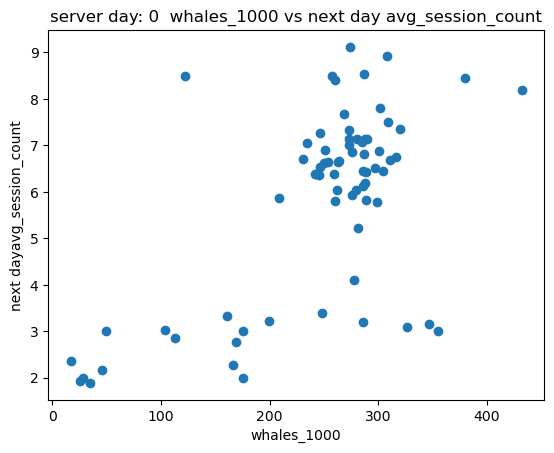

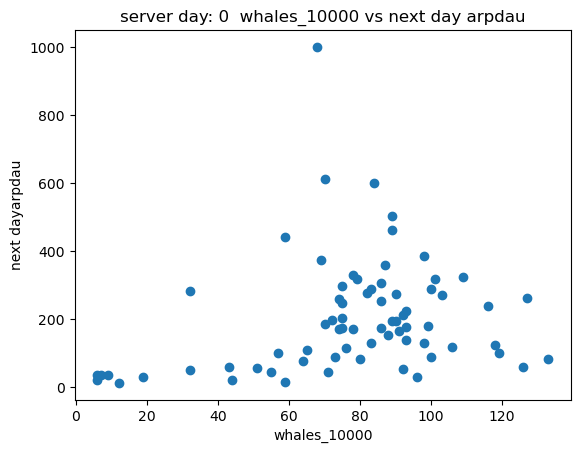

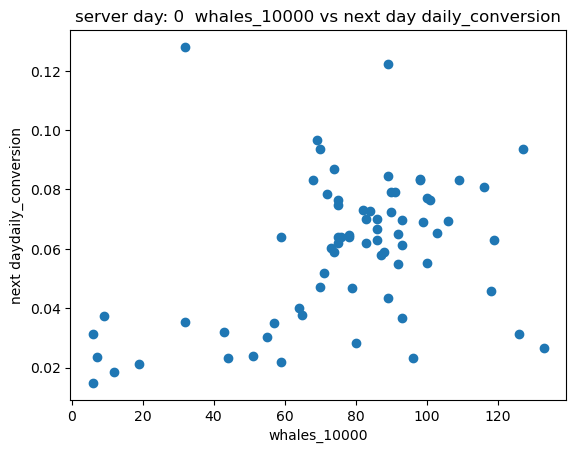

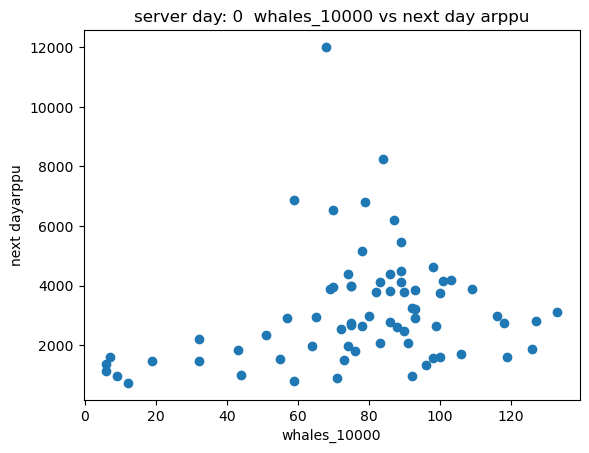

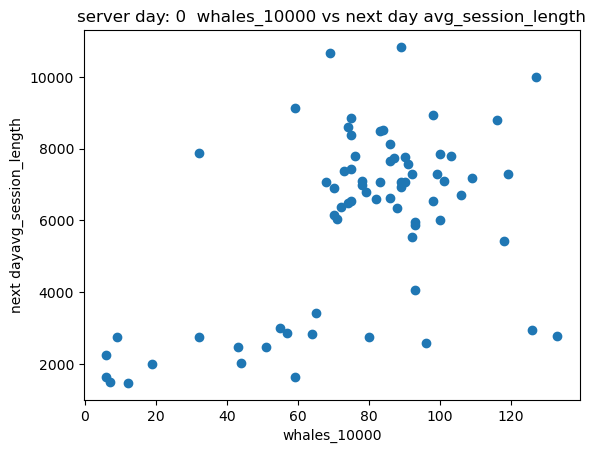

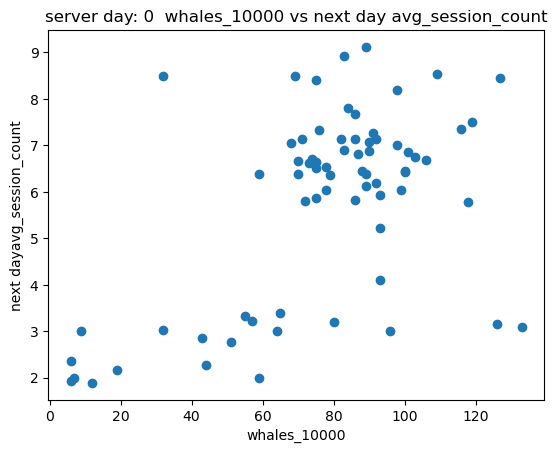

In [42]:
sd = 0
x = 'server_total_account'
for y in ('arpdau', 'daily_conversion', 'arppu', 'avg_session_length', 'avg_session_count'):
    plt.figure()
    plt.scatter(df_server_status.loc[df_server_status['server_day']==sd, x].values, 
                df_server_status.loc[df_server_status['server_day']==sd, y].values)
    plt.title('server day: ' + str(0) + '  ' + x + ' vs ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

sd = 0
for x in ('whales_1000', 'whales_10000'):
    for y in ('arpdau', 'daily_conversion', 'arppu', 'avg_session_length', 'avg_session_count'):
        plt.figure()
        df0 = df_server_status.loc[df_server_status['server_day']==sd, ['server_id', x]]
        df1 = df_server_status.loc[df_server_status['server_day']==sd+1, ['server_id', y]]
        df = df0.merge(df1, on='server_id')
        plt.scatter(df[x].values, 
                    df[y].values)
        plt.title('server day: ' + str(0) + '  ' + x + ' vs next day ' + y)
        plt.xlabel(x)
        plt.ylabel('next day' + y)
        plt.show()

In [60]:
df_player_status_full = df_player_status.merge(df_server_status, how='inner', on=['server_id', 'dt']).fillna(0.0)

df_player_status_full['player_server_first_day_diff'] = df_player_status_full['server_day'] - df_player_status_full['retention_day']

df_player_status_full

,dt,ctwid,session_length,pay_amt,pay_count,server_id,session_count,acc_pay_amt,acc_pay_count,retention_day,...,sum_pay_count,spenders,whales_1000,whales_10000,avg_session_length,avg_session_count,arpdau,daily_conversion,arppu,player_server_first_day_diff
0,2024-11-17,5601d6307c,1898,0.0,0.0,3,2,0.0,0.0,25,...,162.0,47,60,19.0,7539.628726,8.034327,317.255646,0.042457,7472.382979,0
1,2024-11-17,c7912ee7e4,3467,100.0,1.0,3,3,0.0,0.0,25,...,162.0,47,60,19.0,7539.628726,8.034327,317.255646,0.042457,7472.382979,0
2,2024-11-17,9c3f42dcd4,8865,0.0,0.0,3,25,0.0,0.0,25,...,162.0,47,60,19.0,7539.628726,8.034327,317.255646,0.042457,7472.382979,0
3,2024-11-17,fd9ee212a5,2056,0.0,0.0,3,8,0.0,0.0,25,...,162.0,47,60,19.0,7539.628726,8.034327,317.255646,0.042457,7472.382979,0
4,2024-11-17,218defe5ea,1925,0.0,0.0,3,4,0.0,0.0,25,...,162.0,47,60,19.0,7539.628726,8.034327,317.255646,0.042457,7472.382979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853148,2024-11-13,8bcf79066e,19276,0.0,0.0,17,8,0.0,0.0,5,...,184.0,54,40,16.0,9028.629151,8.073801,417.634686,0.099631,4191.814815,0
853149,2024-11-13,b42df4508a,6505,0.0,0.0,17,23,0.0,0.0,5,...,184.0,54,40,16.0,9028.629151,8.073801,417.634686,0.099631,4191.814815,0
853150,2024-11-13,cb2e5c03da,2789,0.0,0.0,17,5,0.0,0.0,5,...,184.0,54,40,16.0,9028.629151,8.073801,417.634686,0.099631,4191.814815,0
853151,2024-11-13,605a701427,4348,0.0,0.0,17,4,0.0,0.0,5,...,184.0,54,40,16.0,9028.629151,8.073801,417.634686,0.099631,4191.814815,0


<Axes: >

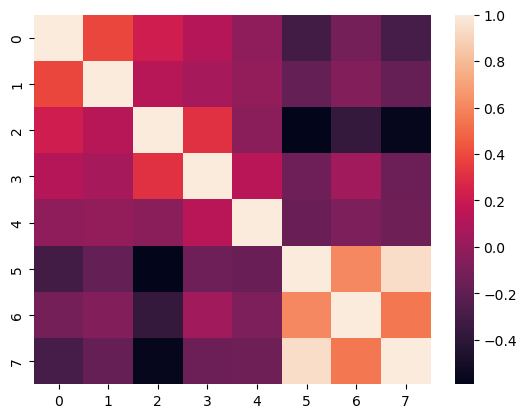

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, mean_squared_log_error, mean_squared_error
import xgboost as xgb
import seaborn as sns

c_X = ['session_length', 'session_count', 'retention_day', 'server_total_account', 'player_server_first_day_diff', 
       'daily_active_account', 'spenders', 'whales_10000']
c_y = ['pay_amt',]

X = df_player_status_full[c_X].values
y = np.sign(df_player_status_full[c_y].values)  # conversion rate

sns.heatmap(np.corrcoef(X.T))

[0]	validation_0-logloss:0.19656
[1]	validation_0-logloss:0.17630
[2]	validation_0-logloss:0.16237
[3]	validation_0-logloss:0.15270
[4]	validation_0-logloss:0.14587
[5]	validation_0-logloss:0.14107
[6]	validation_0-logloss:0.13768
[7]	validation_0-logloss:0.13529
[8]	validation_0-logloss:0.13359
[9]	validation_0-logloss:0.13237
[10]	validation_0-logloss:0.13148
[11]	validation_0-logloss:0.13088
[12]	validation_0-logloss:0.13041
[13]	validation_0-logloss:0.13009
[14]	validation_0-logloss:0.12985
[15]	validation_0-logloss:0.12968
[16]	validation_0-logloss:0.12955
[17]	validation_0-logloss:0.12945
[18]	validation_0-logloss:0.12938
[19]	validation_0-logloss:0.12933
[20]	validation_0-logloss:0.12927
[21]	validation_0-logloss:0.12924
[22]	validation_0-logloss:0.12922
[23]	validation_0-logloss:0.12921
[24]	validation_0-logloss:0.12920
[25]	validation_0-logloss:0.12918
[26]	validation_0-logloss:0.12918
[27]	validation_0-logloss:0.12917
[28]	validation_0-logloss:0.12916
[29]	validation_0-loglos

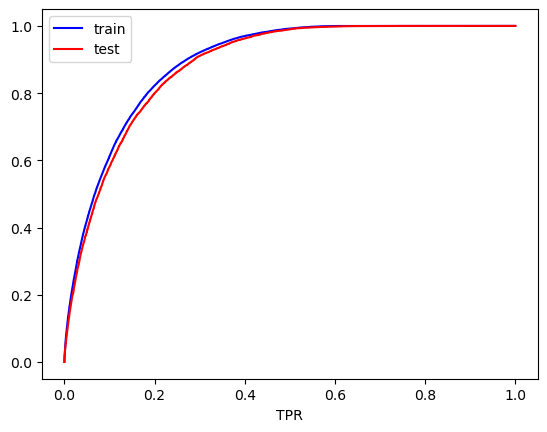

Training AUC Score: 0.893
Testing AUC Score: 0.884
Training F1 Score: 0.284
Testing F1 Score: 0.258


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_p_train, y_p_test = clf.predict_proba(X_train)[:,1], clf.predict_proba(X_test)[:,1]
p = 0.25
y_h_train, y_h_test = y_p_train > p, y_p_test > p

plt.figure()
fpr, tpr, _ = roc_curve(y_train.reshape(-1,), y_p_train.reshape(-1,))
plt.plot(fpr, tpr, 'b', label='train')
fpr, tpr, _ = roc_curve(y_test.reshape(-1,), y_p_test.reshape(-1,))
plt.plot(fpr, tpr, 'r', label='test')
plt.legend()
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.show()
print('Training AUC Score: %.3f' % roc_auc_score(y_train.reshape(-1,), y_p_train.reshape(-1,)))
print('Testing AUC Score: %.3f' % roc_auc_score(y_test.reshape(-1,), y_p_test.reshape(-1,)))
print('Training F1 Score: %.3f' % f1_score(y_train.reshape(-1,), y_h_train.reshape(-1,)))
print('Testing F1 Score: %.3f' % f1_score(y_test.reshape(-1,), y_h_test.reshape(-1,)))

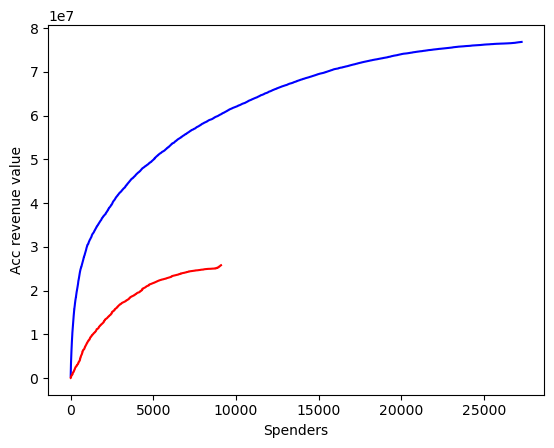

In [165]:
X2 = df_player_status_full.loc[df_player_status_full.index[np.where(df_player_status_full[c_y] > 0)[0]], c_X].values
y2 = df_player_status_full.loc[df_player_status_full.index[np.where(df_player_status_full[c_y] > 0)[0]], c_y].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

clf2 = xgb.XGBRegressor(tree_method="hist", eval_metric=mean_squared_log_error)
clf2.fit(X2_train, y2_train)

y2_h_train, y2_h_test = clf2.predict(X2_train), clf2.predict(X2_test)
y2_h_train_arg = (-y2_h_train).argsort()
y2_h_test_arg = (-y2_h_test).argsort()

plt.figure()
plt.plot(np.cumsum(y2_train[y2_h_train_arg]), 'b')
plt.plot(np.cumsum(y2_test[y2_h_test_arg]), 'r')
plt.xlabel('Spenders')
plt.ylabel('Acc revenue value')
plt.show()

In [166]:
df_X_scenario = df_player_status_full.loc[(df_player_status_full['server_day']==0) & 
                                          (df_player_status_full['player_server_first_day_diff']==0), c_X].copy()
df_conversion = pd.DataFrame(index=range(3000, 8000, 500), columns=range(30, 150, 5))
df_arpdau = df_conversion.copy()
for n_account in df_conversion.index:
    for n_whales in df_conversion.columns:
        df_X_scenario.loc[:, 'server_total_account'] = n_account
        df_X_scenario.loc[:, 'whales_10000'] = n_whales
        conversion_scenario = clf.predict_proba(df_X_scenario.values)[:,1]
        arpdau_scenario = conversion_scenario * clf2.predict(df_X_scenario.values)
        df_conversion.loc[n_account, n_whales] = conversion_scenario.mean()
        df_arpdau.loc[n_account, n_whales] = arpdau_scenario.mean()


C:\Users\shenghq\AppData\Local\Temp\ipykernel_20360\3146278070.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_X_scenario.loc[:, 'server_total_account'] = n_account
C:\Users\shenghq\AppData\Local\Temp\ipykernel_20360\3146278070.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_X_scenario.loc[:, 'whales_10000'] = n_whales


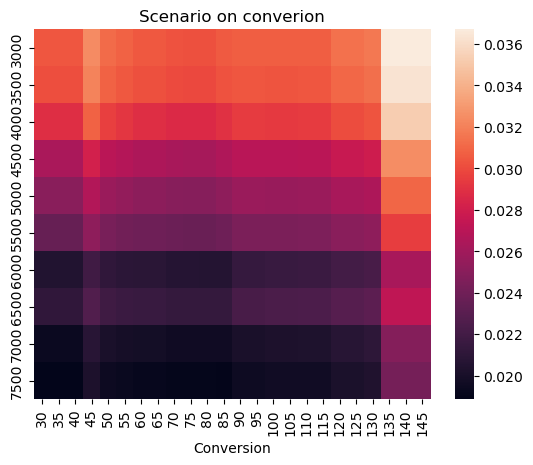

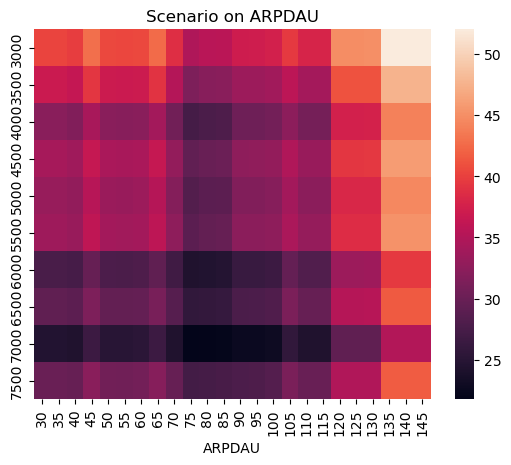

In [167]:
plt.figure()
sns.heatmap(df_conversion.astype(float))
plt.title('Scenario on converion')
plt.xlabel('whales_10000')
plt.xlabel('Conversion')
plt.show()

plt.figure()
sns.heatmap(df_arpdau.astype(float))
plt.title('Scenario on ARPDAU')
plt.xlabel('whales_10000')
plt.xlabel('ARPDAU')
plt.show()